# Libraries

In [4]:
!pip install rouge_score
!pip install evaluate
!pip install datasets
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
import re
from collections import Counter
from datasets import load_dataset, load_metric
from rouge import Rouge

# Data

In [6]:
ds = load_dataset('cnn_dailymail', '3.0.0')

df_train = ds["train"]
print(df_train.shape)
df_test = ds["test"]
print(df_test.shape)
df_validation = ds["validation"]
print(df_validation.shape)





Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

KeyboardInterrupt: ignored

In [ ]:
df_train.columns

Index(['id', 'article', 'highlights'], dtype='object')

# EDA

In [ ]:
# Number of documents per set

In [ ]:
# Length of text
def text_length(df):
  df["words_article"] = df["article"].apply(lambda n: len(n.split()))
  df["words_summary"] = df["highlights"].apply(lambda n: len(n.split()))
  df["summary_perc"] = df["words_summary"]/df["words_article"] 
  return df

df_train = text_length(df_train)
df_validation = text_length(df_validation)
df_test = text_length(df_test)

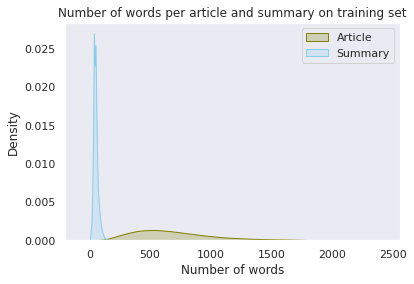

Average number of words in article: 691.8694938926485 and in summary: 51.574101486174435


In [ ]:
# Plots
sns.set(style="darkgrid")
fig = sns.kdeplot(df_train['words_article'], shade=True, color="olive", label='Article')
fig = sns.kdeplot(df_train['words_summary'], shade=True, color="skyblue", label='Summary')
plt.title("Number of words per article and summary on training set")
plt.legend()
plt.grid(False)
plt.xlabel("Number of words")
plt.show()
print("Average number of words in article: {} and in summary: {}".format(df_train['words_article'].mean(), df_train['words_summary'].mean()))

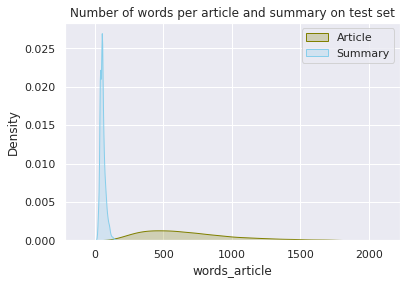

Average number of words in article: 683.5115752828547 and in summary: 55.00931244560488


In [ ]:
sns.set(style="darkgrid")
fig = sns.kdeplot(df_test['words_article'], shade=True, color="olive", label='Article')
fig = sns.kdeplot(df_test['words_summary'], shade=True, color="skyblue", label='Summary')
plt.title("Number of words per article and summary on test set")
plt.legend()
plt.show()
print("Average number of words in article: {} and in summary: {}".format(df_test['words_article'].mean(), df_test['words_summary'].mean()))

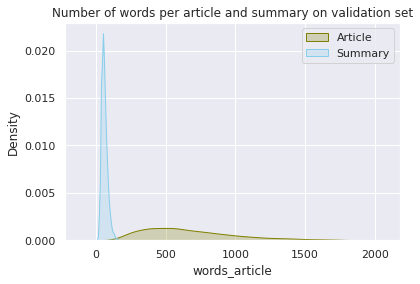

Average number of words in article: 676.0264063435069 and in summary: 57.91008378216637


In [ ]:
sns.set(style="darkgrid")
fig = sns.kdeplot(df_validation['words_article'], shade=True, color="olive", label='Article')
fig = sns.kdeplot(df_validation['words_summary'], shade=True, color="skyblue", label='Summary')
plt.title("Number of words per article and summary on validation set")
plt.legend()
plt.show()
print("Average number of words in article: {} and in summary: {}".format(df_validation['words_article'].mean(), df_validation['words_summary'].mean()))

In [ ]:
# COSINE SIMILARITY
WORD = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    vec1 = text_to_vector(vec1)
    vec2 = text_to_vector(vec2)
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

df_train["cosine_sim"] = np.nan
# for i in range(df_train.shape[0]):

#   df_train["cosine_sim"][i] = get_cosine(df_train["article"][i[], df_train["highlights"]][i])
df_train["cosine_sim"] = df_train.apply(lambda x: get_cosine(x['article'], x['highlights']), 
                        axis=1)


df_train["cosine_sim"].describe()

count    287113.000000
mean          0.513880
std           0.126194
min           0.000000
25%           0.426975
50%           0.517220
75%           0.603956
max           0.919394
Name: cosine_sim, dtype: float64

Text(0, 0.5, 'Number of news/articles')

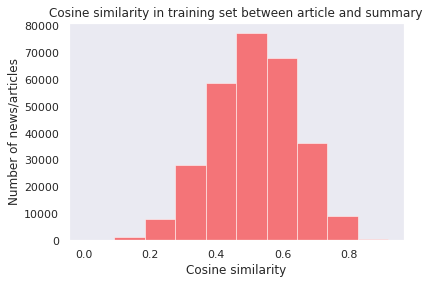

In [ ]:
df_train["cosine_sim"].hist(alpha =0.5, color="red")
plt.title("Cosine similarity in training set between article and summary")
plt.grid(False)
plt.xlabel("Cosine similarity")
plt.ylabel("Number of news/articles")

# Baseline for models

In [ ]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import sent_tokenize
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(df_test["article"][0]))

Ever noticed how plane seats appear to be getting smaller and smaller?
With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk.
They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger.


In [ ]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["article"]]
    return metric.compute(predictions=summaries, references=dataset["highlights"])

In [ ]:
import evaluate
rouge_score = evaluate.load("rouge")
score = evaluate_baseline(df_test, rouge_score)

In [ ]:
df_test.article[0]

"Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee.\xa0'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowding on planes lead to more serious issues than fighting for sp

In [ ]:
df_test.highlights[0]

'Experts question if  packed out planes are putting passengers at risk .\nU.S consumer advisory group says minimum space must be stipulated .\nSafety tests conducted on planes with more leg room than airlines offer .'

In [ ]:
score

{'rouge1': 0.3864199221356889,
 'rouge2': 0.17003016955317096,
 'rougeL': 0.24438852006822628,
 'rougeLsum': 0.3526299311977813}

In [ ]:
# https://huggingface.co/course/chapter7/5?fw=tf